In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Configuration
base_path = "DS"  # Adjust the path according to your dataset location
subjects = range(6, 7)
runs     = range(1, 11)
eeg_labels = [
    "F3","F1","Fz","F2","F4","FFC5h","FFC3h","FFC1h","FFC2h","FFC4h","FFC6h",
    "FC5","FC3","FC1","FCz","FC2","FC4","FC6","FTT7h","FCC5h","FCC3h","FCC6h",
    "FTT8h","C5","C3","C1","Cz","C2","C4","C6","TTP7h",
    "CCP5h","CCP3h","CCP1h","CCP2h","CCP4h","CCP6h","TTP8h","CP5","CP3","CP1",
    "CPz","CPP5h","CPP3h","CPP1h","CPP2h","CPP4h","CPP6h","P3","P1","Pz","P2","P4","PPO1h",
    "PPO2h"
]
# only interested in these event codes
event_codes = [1, 2, 5, 6]
# mapping original codes to 0-3
label_map = {1: 0, 2: 1, 5: 2, 6: 3}

X_list, y_list = [], []
for subj in subjects:
    for run in runs:
        fp = f"{base_path}/S{subj}_MI/motorimagination_subject{subj}_run{run}.gdf"
        raw = mne.io.read_raw_gdf(fp, preload=True, verbose=False)
        to_keep = [ch for ch in eeg_labels if ch in raw.ch_names]
        raw.pick_channels(to_keep)
        raw.filter(0.5, 50.0, verbose=False)

        events, _ = mne.events_from_annotations(raw)
        epochs = mne.Epochs(
            raw, events, event_codes,
            tmin=-1.5, tmax=1.0,
            baseline=(None, 0.0),
            preload=True, verbose=False
        )

        data   = epochs.get_data()            # (n_epochs, n_ch, n_times)
        labels = epochs.events[:, 2].astype(int)  # (n_epochs,)

        # keep only epochs without NaNs
        mask = ~np.isnan(data).any(axis=(1, 2))
        valid_data   = data[mask]
        valid_labels = labels[mask]

        # map labels 1,2,5,6 -> 0,1,2,3
        valid_labels_mapped = np.array([label_map[l] for l in valid_labels], dtype=int)

        X_list.append(valid_data)
        y_list.append(valid_labels_mapped)

# concatenate all runs
X = np.concatenate(X_list, axis=0)  # (n_epochs, n_ch, n_times)
y = np.concatenate(y_list, axis=0)  # (n_epochs,)

print("After filtering & mapping:", X.shape, "labels:", np.unique(y), np.bincount(y))


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1536', '1537', '1538', '1539', '1540', '1541', '1542', '33536', '33554', '34304', '34305', '34306', '34307', '34308', '34309', '34310', '768', '785', '786']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1536', '1537', '1538', '1539', '1540', '1541', '1542', '33536', '33554', '34304', '34305', '34306', '34307', '34308', '34309', '34310', '768', '785', '786']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1536', '1537', '1538', '1539', '1540', '1541', '1542', '33536', '33554', '34304', '34305', '34306', '34307', '34308', '34309', '34310', '768', '785', '786']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1536', '1537', '1538', '1539', '1540', '1541', '1542', '33536', '33554', '343

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 1) Prepare sequence data for LSTM
# LSTM expects (samples, timesteps, features)
# we have (epochs, channels, times) → swap to (epochs, times, channels)
X_seq = np.transpose(X, (0, 2, 1)).astype('float32')
# Adjust labels to be in the range [0, n_classes-1] and ensure a 1D array
y_seq = (y.astype('int32').squeeze())  # ensure integer dtype, 1D array, and adjust range

def sliding_windows(X, y, window_size, step=None):
    if step is None:
        step = window_size // 2
    Xw, yw = [], []
    n_epochs, n_times, n_ch = X.shape
    for i in range(n_epochs):
        for start in range(0, n_times - window_size + 1, step):
            Xw.append(X[i, start:start+window_size, :])
            yw.append(y[i])
    return np.array(Xw, dtype='float32'), np.array(yw, dtype='int32')

# ─── Example usage ───────────────────────────────────────────────────────────
window_size = 5   #->window size
step        = 2  #->  overlap

X_windows, y_windows = sliding_windows(X_seq, y_seq, window_size, step)

print("Windowed X shape:", X_windows.shape)  # (n_windows, 10, n_channels)
print("Windowed y shape:", y_windows.shape)  # (n_windows,)

X_tr, X_temp, y_tr, y_temp = train_test_split(
    X_windows, y_windows,
    test_size=0.3,
    random_state=42,
    stratify=y_windows
)
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# 1) Debug print
print("Before casting:")
print("  X_train dtype:", X_tr.dtype, "X_test dtype:",  X_te.dtype)
print("  y_train dtype:", y_tr.dtype, "y_test dtype:",  y_te.dtype)

# 2) Force numeric types
X_train = X_tr.astype('float32')
X_test  = X_te.astype('float32')
y_train = y_tr.astype('int32')
y_test  = y_te.astype('int32')

print("After casting:")
print("  X_train dtype:", X_train.dtype, "X_test dtype:",  X_test.dtype)
print("  y_train dtype:", y_train.dtype, "y_test dtype:",  y_test.dtype)



Windowed X shape: (136746, 5, 55)
Windowed y shape: (136746,)
Before casting:
  X_train dtype: float32 X_test dtype: float32
  y_train dtype: int32 y_test dtype: int32
After casting:
  X_train dtype: float32 X_test dtype: float32
  y_train dtype: int32 y_test dtype: int32


# **LSTM**

Epoch 1/100


C:\Users\ik111\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2992/2992 - 13s - 4ms/step - accuracy: 0.3307 - loss: 1.3383 - val_accuracy: 0.3822 - val_loss: 1.2799
Epoch 2/100
2992/2992 - 10s - 3ms/step - accuracy: 0.4058 - loss: 1.2500 - val_accuracy: 0.4425 - val_loss: 1.1960
Epoch 3/100
2992/2992 - 10s - 3ms/step - accuracy: 0.4548 - loss: 1.1745 - val_accuracy: 0.4811 - val_loss: 1.1310
Epoch 4/100
2992/2992 - 10s - 3ms/step - accuracy: 0.4947 - loss: 1.1105 - val_accuracy: 0.5150 - val_loss: 1.0728
Epoch 5/100
2992/2992 - 10s - 3ms/step - accuracy: 0.5274 - loss: 1.0558 - val_accuracy: 0.5362 - val_loss: 1.0383
Epoch 6/100
2992/2992 - 10s - 3ms/step - accuracy: 0.5492 - loss: 1.0159 - val_accuracy: 0.5581 - val_loss: 0.9913
Epoch 7/100
2992/2992 - 10s - 3ms/step - accuracy: 0.5670 - loss: 0.9773 - val_accuracy: 0.5685 - val_loss: 0.9692
Epoch 8/100
2992/2992 - 10s - 3ms/step - accuracy: 0.5850 - loss: 0.9477 - val_accuracy: 0.5962 - val_loss: 0.9243
Epoch 9/100
2992/2992 - 10s - 3ms/step - accuracy: 0.6060 - loss: 0.9128 - val_accuracy: 0.6

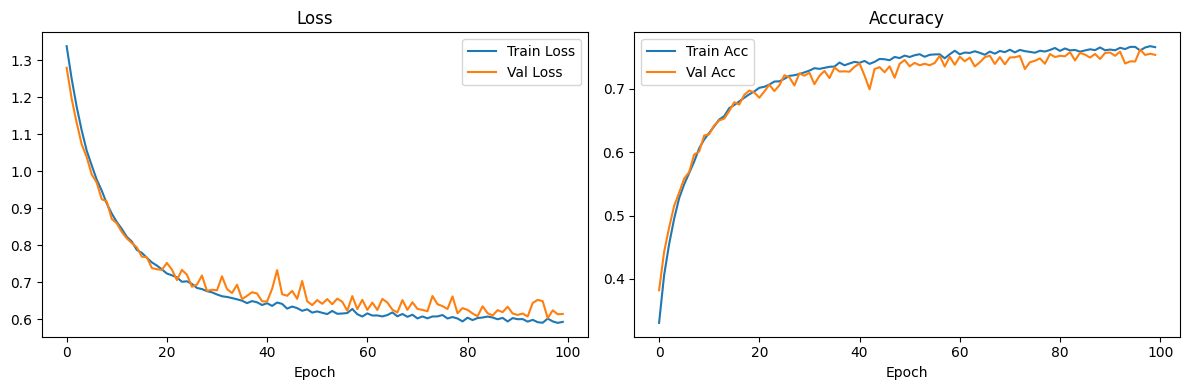

In [3]:

model = Sequential([
    LSTM(50, return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(4, activation='softmax'),
])
model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=32, verbose=2
)

test_loss, test_acc = model.evaluate(X_te, y_te, batch_size=32, verbose=0)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc:.2%}")


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],   label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],   label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# **CNN**

C:\Users\ik111\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 32)          │         5,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,548 (111.52 KB)

 Trainable params: 28,548 (111.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3052 - loss: 1.3748 - val_accuracy: 0.3514 - val_loss: 1.2900
Epoch 2/100
2992/2992 - 7s - 2ms/step - accuracy: 0.3624 - loss: 1.2775 - val_accuracy: 0.4023 - val_loss: 1.2194
Epoch 3/100
2992/2992 - 7s - 2ms/step - accuracy: 0.4145 - loss: 1.2015 - val_accuracy: 0.4718 - val_loss: 1.1336
Epoch 4/100
2992/2992 - 7s - 2ms/step - accuracy: 0.4643 - loss: 1.1302 - val_accuracy: 0.5007 - val_loss: 1.0676
Epoch 5/100
2992/2992 - 7s - 2ms/step - accuracy: 0.5001 - loss: 1.0691 - val_accuracy: 0.5295 - val_loss: 1.0160
Epoch 6/100
2992/2992 - 7s - 2ms/step - accuracy: 0.5298 - loss: 1.0220 - val_accuracy: 0.5534 - val_loss: 0.9688
Epoch 7/100
2992/2992 - 7s - 2ms/step - accuracy: 0.5512 - loss: 0.9815 - val_accuracy: 0.5905 - val_loss: 0.9106
Epoch 8/100
2992/2992 - 7s - 2ms/step - accuracy: 0.5717 - loss: 0.9469 - val_accuracy: 0.5954 - val_loss: 0.9017
Epoch 9/100
2992/2992 - 7s - 2ms/step - accuracy: 0.5906 - loss: 0.9162 - val_accuracy: 

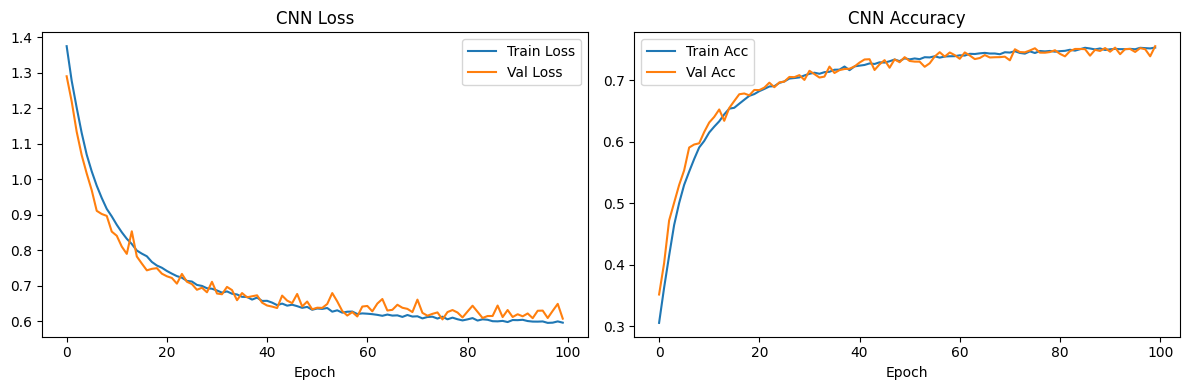

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# CNN Configuration
n_classes = 4
window_size = X_train.shape[1]
n_channels = X_train.shape[2]

#Build & compile 1D‐CNN
model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same',
           input_shape=(window_size, n_channels)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    # Removed second MaxPooling1D to avoid negative output size
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])
model_cnn.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_cnn.summary()


history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=2
)


loss_cnn, acc_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN Test Loss: {loss_cnn:.4f} | CNN Test Accuracy: {acc_cnn:.2%}")


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss');
plt.xlabel('Epoch');
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy');
plt.xlabel('Epoch');
plt.legend()

plt.tight_layout()
plt.show()

# **BI-LSTM**

C:\Users\ik111\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 5, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,204 (403.14 KB)

 Trainable params: 103,204 (403.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2992/2992 - 19s - 7ms/step - accuracy: 0.3547 - loss: 1.3112 - val_accuracy: 0.4072 - val_loss: 1.2405
Epoch 2/100
2992/2992 - 15s - 5ms/step - accuracy: 0.4380 - loss: 1.1978 - val_accuracy: 0.4707 - val_loss: 1.1387
Epoch 3/100
2992/2992 - 14s - 5ms/step - accuracy: 0.4925 - loss: 1.1101 - val_accuracy: 0.5187 - val_loss: 1.0625
Epoch 4/100
2992/2992 - 14s - 5ms/step - accuracy: 0.5359 - loss: 1.0351 - val_accuracy: 0.5435 - val_loss: 1.0179
Epoch 5/100
2992/2992 - 15s - 5ms/step - accuracy: 0.5702 - loss: 0.9724 - val_accuracy: 0.5850 - val_loss: 0.9505
Epoch 6/100
2992/2992 - 15s - 5ms/step - accuracy: 0.5982 - loss: 0.9194 - val_accuracy: 0.6030 - val_loss: 0.9056
Epoch 7/100
2992/2992 - 15s - 5ms/step - accuracy: 0.6236 - loss: 0.8739 - val_accuracy: 0.6391 - val_loss: 0.8460
Epoch 8/100
2992/2992 - 15s - 5ms/step - accuracy: 0.6431 - loss: 0.8325 - val_accuracy: 0.6484 - val_loss: 0.8192
Epoch 9/100
2992/2992 - 15s - 5ms/step - accuracy: 0.6619 - loss: 0.7984 - val_a

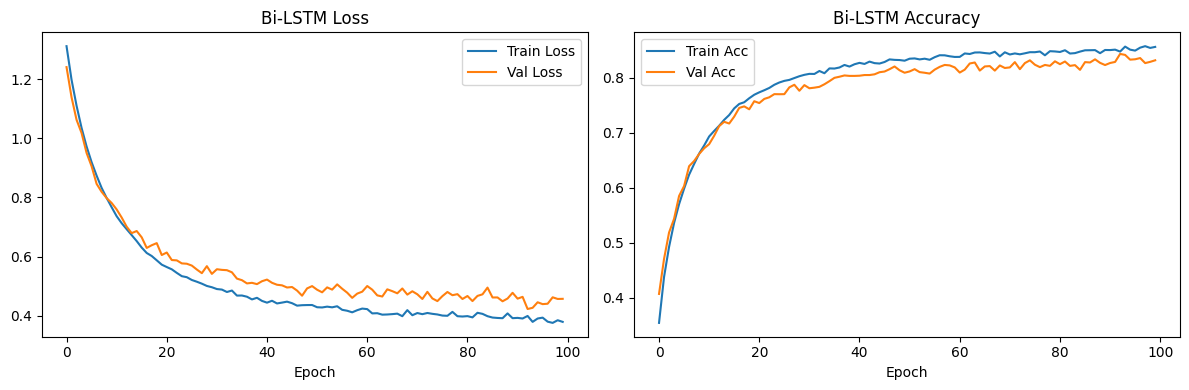

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


n_classes = len(np.unique(y_train))  # number of classes, e.g., 4
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model_bi = Sequential([
    Bidirectional(LSTM(50, return_sequences=True),
                  input_shape=(timesteps, n_features)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model_bi.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_bi.summary()


history_bi = model_bi.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=2
)


test_loss_bi, test_acc_bi = model_bi.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"\nBi-LSTM Test Loss: {test_loss_bi:.4f} | Bi-LSTM Test Accuracy: {test_acc_bi:.2%}")


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_bi.history['loss'],   label='Train Loss')
plt.plot(history_bi.history['val_loss'], label='Val Loss')
plt.title('Bi-LSTM Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_bi.history['accuracy'],   label='Train Acc')
plt.plot(history_bi.history['val_accuracy'], label='Val Acc')
plt.title('Bi-LSTM Accuracy'); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()


# **RNN**

Epoch 1/100
2992/2992 - 11s - 4ms/step - accuracy: 0.2718 - loss: 1.4133 - val_accuracy: 0.2973 - val_loss: 1.3719
Epoch 2/100
2992/2992 - 8s - 3ms/step - accuracy: 0.2973 - loss: 1.3714 - val_accuracy: 0.3267 - val_loss: 1.3549
Epoch 3/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3210 - loss: 1.3574 - val_accuracy: 0.3435 - val_loss: 1.3398
Epoch 4/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3395 - loss: 1.3371 - val_accuracy: 0.3626 - val_loss: 1.3121
Epoch 5/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3633 - loss: 1.3152 - val_accuracy: 0.3905 - val_loss: 1.2822
Epoch 6/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3816 - loss: 1.2910 - val_accuracy: 0.4011 - val_loss: 1.2595
Epoch 7/100
2992/2992 - 8s - 3ms/step - accuracy: 0.3960 - loss: 1.2677 - val_accuracy: 0.4160 - val_loss: 1.2354
Epoch 8/100
2992/2992 - 8s - 3ms/step - accuracy: 0.4158 - loss: 1.2439 - val_accuracy: 0.4424 - val_loss: 1.2083
Epoch 9/100
2992/2992 - 8s - 3ms/step - accuracy: 0.4316 - loss: 1.2228 - val_accuracy:

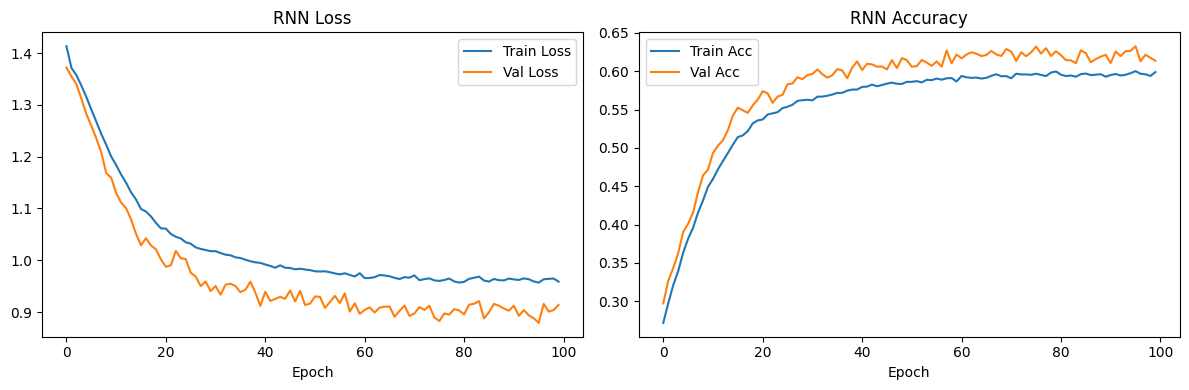

In [6]:
from tensorflow.keras.layers import SimpleRNN

# Build & compile a vanilla RNN model
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(4, activation='softmax'),  # Adjust number of classes as needed
])

rnn_model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=32, verbose=2
)

# Evaluate
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_te, y_te, batch_size=32, verbose=0)
print(f"\nRNN Test loss: {rnn_test_loss:.4f} | Test accuracy: {rnn_test_acc:.2%}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rnn_history.history['loss'],   label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.title('RNN Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rnn_history.history['accuracy'],   label='Train Acc')
plt.plot(rnn_history.history['val_accuracy'], label='Val Acc')
plt.title('RNN Accuracy'); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()


# **Bi-RNN**

Epoch 1/100
2992/2992 - 15s - 5ms/step - accuracy: 0.2856 - loss: 1.4106 - val_accuracy: 0.3094 - val_loss: 1.3664
Epoch 2/100
2992/2992 - 11s - 4ms/step - accuracy: 0.3160 - loss: 1.3599 - val_accuracy: 0.3363 - val_loss: 1.3361
Epoch 3/100
2992/2992 - 11s - 4ms/step - accuracy: 0.3458 - loss: 1.3333 - val_accuracy: 0.3591 - val_loss: 1.3102
Epoch 4/100
2992/2992 - 11s - 4ms/step - accuracy: 0.3722 - loss: 1.3021 - val_accuracy: 0.3977 - val_loss: 1.2623
Epoch 5/100
2992/2992 - 11s - 4ms/step - accuracy: 0.4021 - loss: 1.2674 - val_accuracy: 0.4277 - val_loss: 1.2259
Epoch 6/100
2992/2992 - 11s - 4ms/step - accuracy: 0.4277 - loss: 1.2322 - val_accuracy: 0.4522 - val_loss: 1.1921
Epoch 7/100
2992/2992 - 11s - 4ms/step - accuracy: 0.4493 - loss: 1.2019 - val_accuracy: 0.4609 - val_loss: 1.1750
Epoch 8/100
2992/2992 - 12s - 4ms/step - accuracy: 0.4686 - loss: 1.1739 - val_accuracy: 0.4906 - val_loss: 1.1339
Epoch 9/100
2992/2992 - 11s - 4ms/step - accuracy: 0.4849 - loss: 1.1455 - val_a

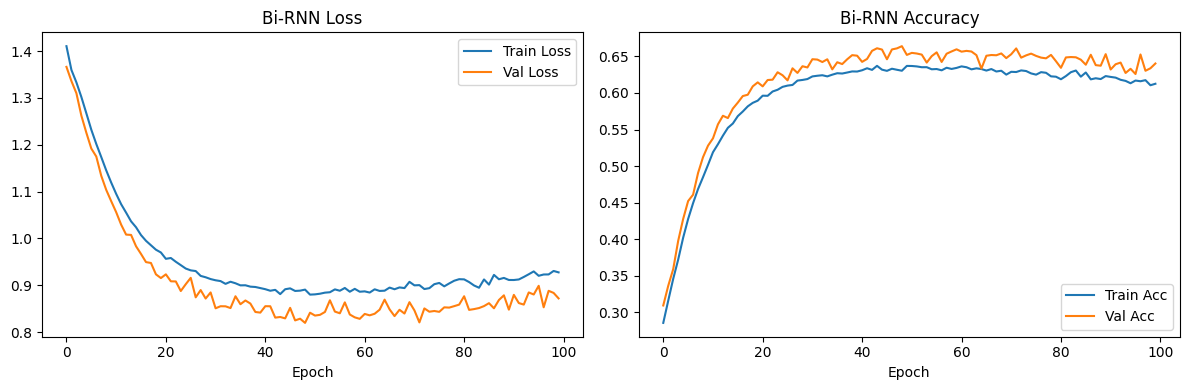

In [7]:
from tensorflow.keras.layers import Bidirectional

# Build & compile a Bi-RNN model
bi_rnn_model = Sequential([
    Bidirectional(SimpleRNN(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(SimpleRNN(50)),
    Dropout(0.2),
    Dense(4, activation='softmax'),  # Adjust number of classes as needed
])

bi_rnn_model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
bi_rnn_history = bi_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=32, verbose=2
)

# Evaluate
bi_rnn_test_loss, bi_rnn_test_acc = bi_rnn_model.evaluate(X_te, y_te, batch_size=32, verbose=0)
print(f"\nBi-RNN Test loss: {bi_rnn_test_loss:.4f} | Test accuracy: {bi_rnn_test_acc:.2%}")


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(bi_rnn_history.history['loss'],   label='Train Loss')
plt.plot(bi_rnn_history.history['val_loss'], label='Val Loss')
plt.title('Bi-RNN Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(bi_rnn_history.history['accuracy'],   label='Train Acc')
plt.plot(bi_rnn_history.history['val_accuracy'], label='Val Acc')
plt.title('Bi-RNN Accuracy'); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()

In [8]:
%pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define the model builder function for the tuner
def build_model(hp):
    model = Sequential()

    units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    use_bidirectional = hp.Boolean('bidirectional')

    # First RNN layer (optionally bidirectional)
    if use_bidirectional:
        model.add(Bidirectional(SimpleRNN(units_1, return_sequences=True),
                                input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(SimpleRNN(units_1, return_sequences=True,
                            input_shape=(X_train.shape[1], X_train.shape[2])))

    dropout_1 = hp.Float('dropout_1', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_1))

    # Second RNN layer (not bidirectional)
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(SimpleRNN(units_2))

    dropout_2 = hp.Float('dropout_2', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_2))

    # Output layer - adjust number of classes as per your problem (7 here)
    model.add(Dense(4, activation='softmax'))

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner - Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,           # Total different hyperparameter combinations to try
    executions_per_trial=1,  # Train each config once (increase for more stable results)
    directory='tuner_dir_v2',
    project_name='eeg_rnn_tuning_v2'
)

# Run hyperparameter search on training data
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(X_te, y_te, batch_size=32)
print(f"\nBest model test accuracy: {test_acc:.2%}")

# Optional: summary of the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
print(f" - units_1: {best_hp.get('units_1')}")
print(f" - bidirectional: {best_hp.get('bidirectional')}")
print(f" - dropout_1: {best_hp.get('dropout_1')}")
print(f" - units_2: {best_hp.get('units_2')}")
print(f" - dropout_2: {best_hp.get('dropout_2')}")
print(f" - learning_rate: {best_hp.get('learning_rate')}")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\ik111\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Reloading Tuner from tuner_dir_v2\eeg_rnn_tuning_v2\tuner0.json



C:\Users\ik111\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2535 - loss: 1.6419

Best model test accuracy: 25.45%

Best hyperparameters:
 - units_1: 96
 - bidirectional: True
 - dropout_1: 0.1
 - units_2: 128
 - dropout_2: 0.4
 - learning_rate: 0.001


Epoch 1/100
2992/2992 - 24s - 8ms/step - accuracy: 0.3520 - loss: 1.3282 - val_accuracy: 0.4293 - val_loss: 1.2214
Epoch 2/100
2992/2992 - 18s - 6ms/step - accuracy: 0.4611 - loss: 1.1607 - val_accuracy: 0.5050 - val_loss: 1.0896
Epoch 3/100
2992/2992 - 18s - 6ms/step - accuracy: 0.5260 - loss: 1.0453 - val_accuracy: 0.5572 - val_loss: 0.9913
Epoch 4/100
2992/2992 - 20s - 7ms/step - accuracy: 0.5759 - loss: 0.9583 - val_accuracy: 0.5891 - val_loss: 0.9376
Epoch 5/100
2992/2992 - 21s - 7ms/step - accuracy: 0.6136 - loss: 0.8874 - val_accuracy: 0.6379 - val_loss: 0.8404
Epoch 6/100
2992/2992 - 20s - 7ms/step - accuracy: 0.6425 - loss: 0.8355 - val_accuracy: 0.6506 - val_loss: 0.8145
Epoch 7/100
2992/2992 - 20s - 7ms/step - accuracy: 0.6697 - loss: 0.7812 - val_accuracy: 0.6745 - val_loss: 0.7709
Epoch 8/100
2992/2992 - 20s - 7ms/step - accuracy: 0.6897 - loss: 0.7453 - val_accuracy: 0.7017 - val_loss: 0.7214
Epoch 9/100
2992/2992 - 20s - 7ms/step - accuracy: 0.7054 - loss: 0.7108 - val_a

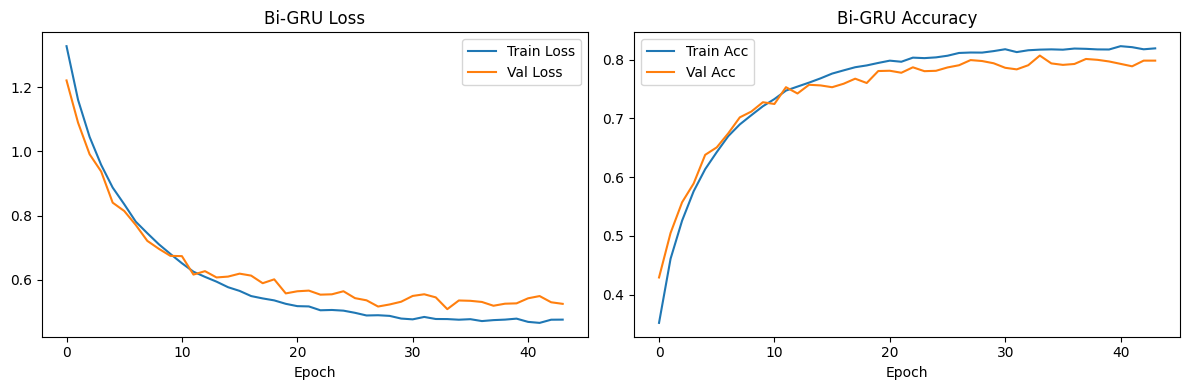

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the model with the best parameters
model = Sequential()

# First GRU layer (Bidirectional)
model.add(Bidirectional(GRU(best_hp.get('units_1'), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(best_hp.get('dropout_1')))

# Second GRU layer
model.add(GRU(best_hp.get('units_2')))
model.add(Dropout(best_hp.get('dropout_2')))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting (restore best weights)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model for 100 epochs
GRU_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_te, y_te, batch_size=32)
print(f"\nFinal model test accuracy: {test_acc:.2%}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(GRU_history.history['loss'],   label='Train Loss')
plt.plot(GRU_history.history['val_loss'], label='Val Loss')
plt.title('Bi-GRU Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(GRU_history.history['accuracy'],   label='Train Acc')
plt.plot(GRU_history.history['val_accuracy'], label='Val Acc')
plt.title('Bi-GRU Accuracy'); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()


GRU

Epoch 1/100
2992/2992 - 20s - 7ms/step - accuracy: 0.3403 - loss: 1.3413 - val_accuracy: 0.4031 - val_loss: 1.2554
Epoch 2/100
2992/2992 - 17s - 6ms/step - accuracy: 0.4398 - loss: 1.2007 - val_accuracy: 0.4805 - val_loss: 1.1407
Epoch 3/100
2992/2992 - 17s - 6ms/step - accuracy: 0.5039 - loss: 1.0931 - val_accuracy: 0.5373 - val_loss: 1.0257
Epoch 4/100
2992/2992 - 17s - 6ms/step - accuracy: 0.5520 - loss: 1.0049 - val_accuracy: 0.5701 - val_loss: 0.9623
Epoch 5/100
2992/2992 - 17s - 6ms/step - accuracy: 0.5940 - loss: 0.9253 - val_accuracy: 0.6102 - val_loss: 0.8922
Epoch 6/100
2992/2992 - 17s - 6ms/step - accuracy: 0.6245 - loss: 0.8685 - val_accuracy: 0.6413 - val_loss: 0.8380
Epoch 7/100
2992/2992 - 17s - 6ms/step - accuracy: 0.6524 - loss: 0.8151 - val_accuracy: 0.6650 - val_loss: 0.7918
Epoch 8/100
2992/2992 - 18s - 6ms/step - accuracy: 0.6759 - loss: 0.7683 - val_accuracy: 0.6740 - val_loss: 0.7733
Epoch 9/100
2992/2992 - 17s - 6ms/step - accuracy: 0.6955 - loss: 0.7304 - val_a

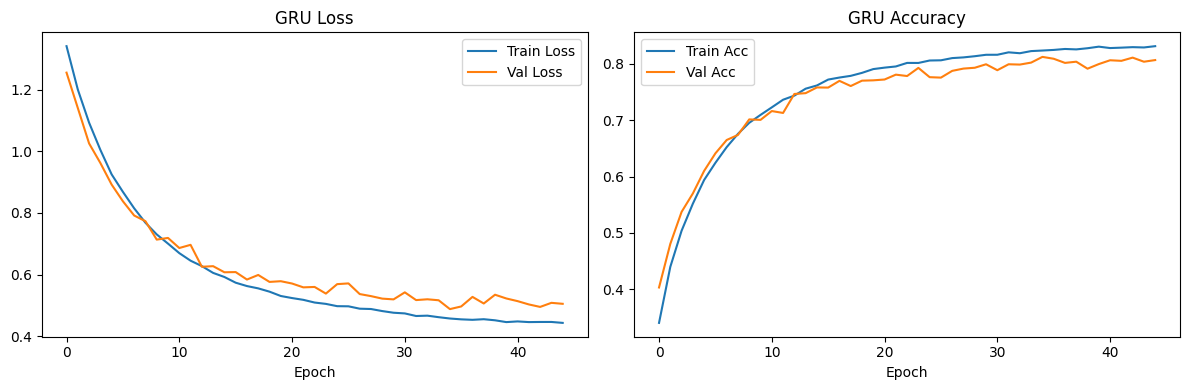

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build the model with the best parameters (unidirectional GRU)
model = Sequential()

# First GRU layer (unidirectional)
model.add(GRU(best_hp.get('units_1'), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(best_hp.get('dropout_1')))

# Second GRU layer (unidirectional)
model.add(GRU(best_hp.get('units_2')))
model.add(Dropout(best_hp.get('dropout_2')))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting (restore best weights)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model for 100 epochs
GRU_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_te, y_te, batch_size=32)
print(f"\nFinal model test accuracy: {test_acc:.2%}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(GRU_history.history['loss'], label='Train Loss')
plt.plot(GRU_history.history['val_loss'], label='Val Loss')
plt.title('GRU Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(GRU_history.history['accuracy'], label='Train Acc')
plt.plot(GRU_history.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy'); plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()
